In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import shap
shap.initjs()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import wquantiles as wq
%matplotlib inline
plt.style.use("ggplot")

In [2]:
df = pd.read_csv('model_ready.csv')

In [3]:
df.head(1)

,pkey,property_value_amt,target,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,delingq_cnt,standing_num,total_debt,monthly_debt,yearly_income,reason_cde_DebtCon,reason_cde_HomeImp,job_cde_Mgr,job_cde_Office,job_cde_Other,job_cde_ProfExe,job_cde_Sales,job_cde_Self,standing_value_Excellent,standing_value_Fair,standing_value_Good,standing_value_Questionable,cluster_group_High Risk,cluster_group_Highest Risk,cluster_group_Low Risk,cluster_group_Lowest Risk
0,0,11.426332,0,20.0,0.0,3.440639,9.903538,10.0,10.255587,0.0,4.97423,0.0,0.0,10.788102,6.003072,9.682654,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0


In [4]:
df = df.set_index('pkey')

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.3, random_state=42)

In [6]:
Y = train['target'].values
X = train.drop('target', axis = 1)

test_Y = test['target'].values
test_X = test.drop(['target'], axis = 1)

### Gradient Boosting Classifier

In [7]:
gbm = GradientBoostingClassifier()

In [8]:
params = {
    'max_depth' : [4,5],
    'learning_rate' : [0.01,0.1],
    'n_estimators' : [100,500]
}

In [9]:
# Randomized search - Parameter tuning
folds = 5
param_comb = 500
skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state= 43)

random_search_gbm_params = RandomizedSearchCV(gbm, param_distributions = params, scoring = 'roc_auc' , n_jobs = 10, cv = skf.split(X,Y), verbose = 3, random_state = 43)
random_search_gbm_params.fit(X,Y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   26.5s
[Parallel(n_jobs=10)]: Done  35 out of  40 | elapsed:   57.7s remaining:    8.2s
[Parallel(n_jobs=10)]: Done  40 out of  40 | elapsed:  1.1min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000011C83DA8248>,
                   error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                      

In [10]:
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search_gbm_params.best_score_ * 2 -1)
print('\n Best hyperparameters:')
print(random_search_gbm_params.best_params_)

results = pd.DataFrame(random_search_gbm_params.cv_results_)


 Best normalized gini score for 5-fold search with 500 parameter combinations:
0.9848791852865784

 Best hyperparameters:
{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1}


In [11]:
def scoring_grp(dtest,alg,predictors, target, pred_threshold):
    
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    dtest['y_pred'] = np.where(((dtest['predprob'] >= pred_threshold)),1,0)
    
    print('AUC Score (Test): %f' % metrics.roc_auc_score(dtest[target], dtest['predprob']))
    gini = 2*metrics.roc_auc_score(dtest[target] , dtest['predprob']) - 1
    print('Gini Score (Test): %f' % gini)
    print('Recall - Test: %f'%  metrics.recall_score(dtest[target] , dtest['y_pred']))
    print('Precision - Test: %f' % metrics.precision_score(dtest[target], dtest['y_pred']))
    print('\n')
    

In [12]:
scoring_grp(test,random_search_gbm_params,X.columns,'target' , 0.4)

AUC Score (Test): 0.993406
Gini Score (Test): 0.986813
Recall - Test: 0.985169
Precision - Test: 0.945763




## Gradient Boosting w/o Parameters

In [13]:
params = {}

folds = 5
param_comb = 500
skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state= 43)

random_search_gbm = RandomizedSearchCV(gbm, param_distributions = params, scoring = 'roc_auc' , n_jobs = 10, cv = skf.split(X,Y), verbose = 3, random_state = 43)
random_search_gbm.fit(X,Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    1.8s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000011C8C27D7C8>,
                   error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                      

In [14]:
scoring_grp(test,random_search_gbm,X.columns,'target' , 0.4)

AUC Score (Test): 0.948849
Gini Score (Test): 0.897698
Recall - Test: 0.911723
Precision - Test: 0.861241




## Decision Tree

## Decision Tree without Parameters

In [15]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()

In [16]:
# Randomized search - with no parameters
param_dist = {}
folds = 5
param_comb = 500
skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state= 43)

random_search_dt = RandomizedSearchCV(dt, param_distributions = params, scoring = 'roc_auc' , cv = skf.split(X,Y), verbose = 3, random_state = 43)
random_search_dt.fit(X,Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] .................................... , score=0.928, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.931, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.945, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.933, total=   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... , score=0.933, total=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000011C8C29B048>,
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
      

In [17]:
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search_dt.best_score_ * 2 -1)
print('\n Best hyperparameters:')
print(random_search_dt.best_params_)

results = pd.DataFrame(random_search_dt.cv_results_)


 Best normalized gini score for 5-fold search with 500 parameter combinations:
0.8682049113500718

 Best hyperparameters:
{}


In [18]:
scoring_grp(test,random_search_dt,X.columns,'target' , 0.4)

AUC Score (Test): 0.943104
Gini Score (Test): 0.886208
Recall - Test: 0.978814
Precision - Test: 0.911842




## Decision Tree With Parameters

In [19]:
dt.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [20]:
# Randomized search - with no parameters
param_dist = {'max_features': 3,
             'max_depth': 5}
folds = 5
param_comb = 500
skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state= 43)

random_search_dt_params = RandomizedSearchCV(dt, param_distributions = params, scoring = 'roc_auc' , cv = skf.split(X,Y), verbose = 3, random_state = 43)
random_search_dt_params.fit(X,Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] .................................... , score=0.930, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.935, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.947, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.927, total=   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... , score=0.938, total=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000011C8C29BCC8>,
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
      

In [21]:
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search_dt_params.best_score_ * 2 -1)
print('\n Best hyperparameters:')
print(random_search_dt_params.best_params_)

results = pd.DataFrame(random_search_dt_params.cv_results_)


 Best normalized gini score for 5-fold search with 500 parameter combinations:
0.8706378476041252

 Best hyperparameters:
{}


In [22]:
scoring_grp(test,random_search_dt_params,X.columns,'target' , 0.4)

AUC Score (Test): 0.944802
Gini Score (Test): 0.889603
Recall - Test: 0.975989
Precision - Test: 0.917054




# XGBoost

In [23]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

### XGBoost w/o Parameters

In [24]:
# Randomized search - Parameter tuning
params = {}
folds = 5
param_comb = 500
skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state= 43)

random_search_xgb = RandomizedSearchCV(xgb, param_distributions = params, scoring = 'roc_auc' , n_jobs = 10, cv = skf.split(X,Y), verbose = 3, random_state = 43)
random_search_xgb.fit(X,Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.5s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    3.0s finished


[16:47:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000011C8C4247C8>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child...
                                           objective='binary:logistic',
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                    

In [25]:
scoring_grp(test,random_search_xgb,X.columns,'target' , 0.4)

AUC Score (Test): 0.994234
Gini Score (Test): 0.988467
Recall - Test: 0.983757
Precision - Test: 0.944407




In [26]:
params = {
    'max_depth' : [4,5],
    'learning_rate' : [0.01,0.1],
    'n_estimators' : [100,500]
}

In [27]:
# Randomized search - Parameter tuning
folds = 5
param_comb = 500
skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state= 43)

random_search_xgb_params = RandomizedSearchCV(xgb, param_distributions = params, scoring = 'roc_auc' , n_jobs = 10, cv = skf.split(X,Y), verbose = 3, random_state = 43)
random_search_xgb_params.fit(X,Y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   13.2s
[Parallel(n_jobs=10)]: Done  35 out of  40 | elapsed:   30.5s remaining:    4.3s
[Parallel(n_jobs=10)]: Done  40 out of  40 | elapsed:   36.8s finished


[16:48:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000011C8C45C248>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           use_label_encoder=True,
                                    

In [28]:
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search_xgb_params.best_score_ * 2 -1)
print('\n Best hyperparameters:')
print(random_search_xgb_params.best_params_)

results = pd.DataFrame(random_search_xgb_params.cv_results_)


 Best normalized gini score for 5-fold search with 500 parameter combinations:
0.9847488723424562

 Best hyperparameters:
{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1}


In [29]:
scoring_grp(test,random_search_xgb_params,X.columns,'target' , 0.4)

AUC Score (Test): 0.994177
Gini Score (Test): 0.988354
Recall - Test: 0.983757
Precision - Test: 0.946332




In [40]:
model_selected = random_search_gbm.best_estimator_

In [ ]:
## Selecting the model with no parameters because adding parameters tends to overfit the model.

In [31]:
## Function for shap plot here, I cannot give this code out because of my contract with ESI

In [32]:
var_cat = pd.read_csv('varaibles_categories.csv')

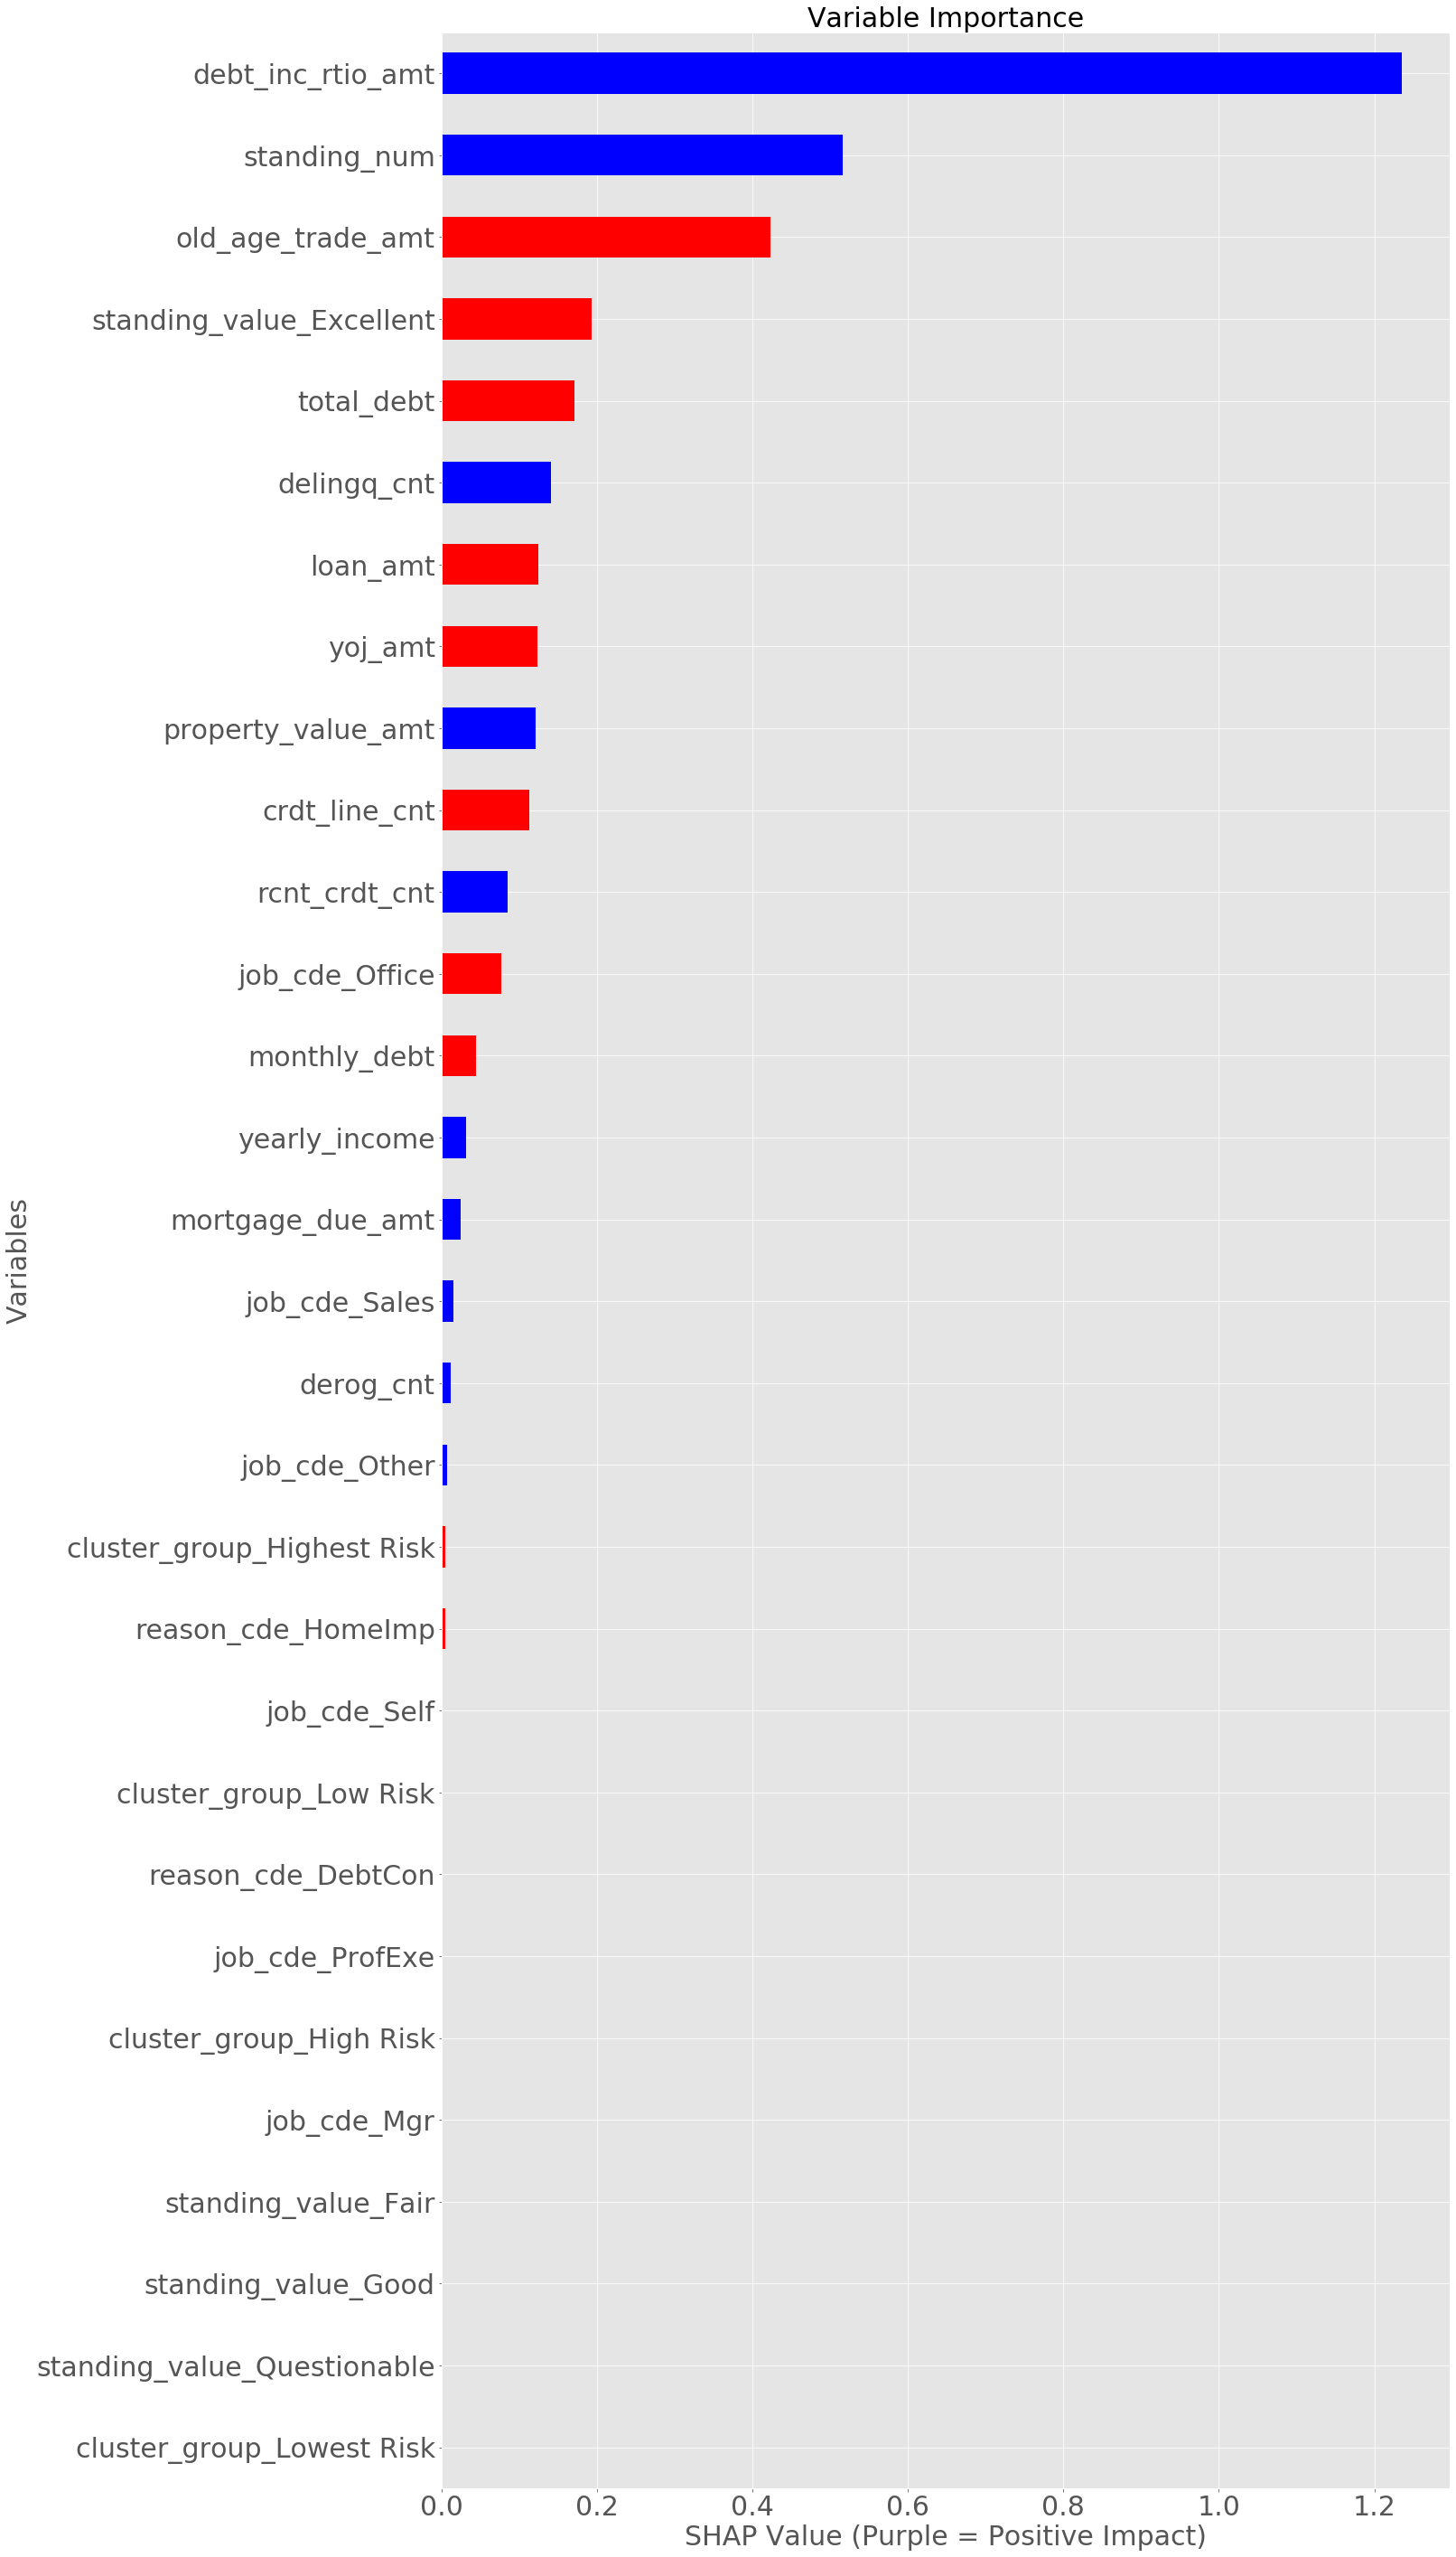

In [41]:
categ1_imp_d,categ1_2_3_imp_d = shap_imp(model_selected,test_X,var_cat)

In [34]:
final = test_X.reset_index()

In [35]:
pred_prob = model_selected.predict_proba(test_X)
pred_prob_1 = model_selected.predict(test_X)
pred = pd.DataFrame(pred_prob, columns = ['zero_pred' , 'one_pred'])
pred_0_1 = pd.DataFrame(pred_prob_1, columns = ['prediction'])

In [36]:
prediction_prob = pred.set_index(final.pkey)
prediction_prob = prediction_prob.reset_index()
prediction_0_1 = pred_0_1.set_index(final.pkey)
prediction_0_1 = prediction_0_1.reset_index()
prediction = pd.merge(prediction_prob,prediction_0_1, on = 'pkey')
final_1 = pd.merge(final,prediction, on = 'pkey').drop_duplicates('pkey')

In [37]:
final_1 = pd.merge(final,prediction, on = 'pkey').drop_duplicates('pkey')

In [38]:
final_1.head()

,pkey,property_value_amt,crdt_line_cnt,derog_cnt,debt_inc_rtio_amt,loan_amt,yoj_amt,mortgage_due_amt,rcnt_crdt_cnt,old_age_trade_amt,delingq_cnt,standing_num,total_debt,monthly_debt,yearly_income,reason_cde_DebtCon,reason_cde_HomeImp,job_cde_Mgr,job_cde_Office,job_cde_Other,job_cde_ProfExe,job_cde_Sales,job_cde_Self,standing_value_Excellent,standing_value_Fair,standing_value_Good,standing_value_Questionable,cluster_group_High Risk,cluster_group_Highest Risk,cluster_group_Low Risk,cluster_group_Lowest Risk,zero_pred,one_pred,prediction
0,3012,11.030671,28.0,3.0,3.836325,10.325515,20.0,9.818801,0.0,4.960766,5.0,8.0,10.797042,5.321301,8.592115,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0.000195,0.999805,1
8,2335,10.747573,0.0,0.0,2.762917,8.794976,0.0,11.082450,0.0,5.161734,0.0,0.0,11.179130,8.694377,13.086558,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0.992868,0.007132,0
9,5511,11.866866,22.0,0.0,3.506575,9.994288,8.0,11.569192,0.0,4.986187,0.0,0.0,11.757345,7.193738,10.806977,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0.995618,0.004382,0
10,4031,11.127278,25.0,0.0,3.578458,9.581973,0.2,10.806673,0.0,5.190732,0.0,0.0,11.064276,10.188829,13.728728,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0.795952,0.204048,0
11,92,10.784752,16.0,0.0,3.411133,9.417436,0.0,10.108589,0.0,5.147931,0.0,0.0,10.514692,8.030084,11.742274,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0.021132,0.978868,1


In [39]:
final_1.prediction.value_counts()

0    1393
1     897
Name: prediction, dtype: int64